# Create_intent_embeddings

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Mounted at /content/drive


In [2]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive/Research/Dietitian_Chatbot_Phase2'
os.chdir(thisdir)

# Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive/Research/Dietitian_Chatbot_Phase2


## Extract example intent sentences from 'intent files'

In [3]:
intent_files = ['intent_Meal-Logging.txt', 'intent_Meal-Planning-Recipes.txt', 'intent_Educational-Content.txt', 'intent_Personalized-Health-Advice.txt']
intents = [fname[7:-4] for fname in intent_files]
print(intents)

['Meal-Logging', 'Meal-Planning-Recipes', 'Educational-Content', 'Personalized-Health-Advice']


In [4]:
import re

def extract_example_sentences(fname):
  """ Read an intent file and extract example sentences.  Sententences are
  grouped into clusters (made by ChatGPT-4o).  Each cluster has a name and
  a list of example sentences.  Clusters are stored in a dictionary and the
  function returns the dictionary.
  """
  f = open(f'./intents/{fname}', 'r', encoding='latin-1') # because of ‘ ’ (\x91 and \x92)
  lines = f.readlines()
  # trim white spaces and fix up '\x91' and '\x92' to "'"
  lines = [line.strip() for line in lines]
  lines = [line.replace('\x92', "'") for line in lines]
  lines = [line.replace('\x91', "'") for line in lines]
  f.close()

  #pattern = r"^\d+\.\s.(*?)"
  pattern = r"^\d+\.\s+(.*)?"
  sentences_dict = {}
  # loop through each line
  i = 0
  nlen = len(lines)

  while (i < nlen):
    # skip to the first/next "#### **Cluster "
    while (i < nlen and not lines[i].startswith("#### **Cluster ")):
      i += 1

    if (i == nlen):
      break

    # extract example sentences for this cluster
    cluster_name = lines[i][18:-2] # get the cluster name
    temp_end = cluster_name.find(" (")
    if temp_end != -1:
      cluster_name = cluster_name[:temp_end]
    print (cluster_name)
    i += 1

    # collect sentences for this cluster
    sentences = []
    while (i < nlen and not lines[i].startswith("---")):
      #print (lines[i])
      if (lines[i].startswith("- ")):
        sentences.append(lines[i][3:-1])
      else:
        z = re.match(pattern, lines[i])
        if (z is not None):
          sentences.append(z.group(1)[1:-1])
      i += 1
    # enter the collected sentences in the dictionary
    sentences_dict[cluster_name] = sentences

  return sentences_dict

In [5]:
temp = extract_example_sentences(intent_files[2])
print (temp)

Nutrition Basics
Ingredient Substitutions
Understanding Food Labels
Diet-Specific Questions
Cooking Tips and Techniques
{'Nutrition Basics': ['What are the basics of a balanced diet?', 'Can you explain macronutrients to me?', 'What are the essential vitamins and minerals I need daily?', 'How many calories should I consume in a day?', "What's the difference between healthy fats and unhealthy fats?", 'What are the benefits of eating whole grains?', 'Can you explain what a plant-based diet is?', 'How much protein do I need daily?', "What's the role of fiber in my diet?", 'What are some examples of nutrient-dense foods?', "What's the importance of hydration in a healthy diet?", "What's the difference between simple and complex carbs?", 'Why are trans fats bad for me?', 'What are good sources of iron?', "How do I know if I'm eating enough vegetables?", 'What are the risks of eating too much sugar?', 'What is the glycemic index, and why does it matter?', 'How does sodium affect my health?', 

In [8]:
# Extract all example sentences from all intents
intents_dict = {}
for fname in intent_files:
  intents_dict[fname[7:-4]] = extract_example_sentences(fname)

# sanity check
print ('==============================')
print (intents_dict['Educational-Content'])

Explicitly Mentioning Meal Logging
Mentioning Specific Meals or Times
Health Tracking Context
Describing Logging Actions or Tasks
Retrospective Meal Tracking
Questions About Logging
General Meal Planning
Specific Meal Requests
Diet-Specific Meal Plans
Recipe Recommendations
Budget-Friendly Meal Planning
Ingredient-Specific Requests
Nutrition Basics
Ingredient Substitutions
Understanding Food Labels
Diet-Specific Questions
Cooking Tips and Techniques
Seeking Advice for Specific Health Conditions
Weight and Fitness-Related Advice
Tailored Advice for Specific Diet Goals
Age-Related Health Advice
Advice for Chronic Illness Management
Preventative Health and Wellness
{'Nutrition Basics': ['What are the basics of a balanced diet?', 'Can you explain macronutrients to me?', 'What are the essential vitamins and minerals I need daily?', 'How many calories should I consume in a day?', "What's the difference between healthy fats and unhealthy fats?", 'What are the benefits of eating whole grains?'

## Use SentenceTransformer to generate sentence embeddings and cluster centroid embeddings

In [6]:
!pip install -U sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: sentence_transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1


In [7]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
import numpy as np

def create_intent_embeddings(intent, intent_dict):
  """ Create a intent embedding for each cluster in the
  intent_dict.  Each embedding is a mean of the sentence
  embeddings in the cluster."""
  print (f'Intent: {intent}')

  emb_dict = {}
  for (cat, sentences) in intent_dict.items():
    #print (cat)
    # 2. Calculate embeddings by calling model.encode()
    embeddings = model.encode(sentences)
    #print(embeddings.shape)
    embedding = np.mean(embeddings, axis=0)
    emb_dict[cat] = embedding
  return emb_dict

In [ ]:
emb_dict = create_intent_embeddings(intents[2], intents_dict[intents[2]])

Intent: Educational-Content


In [10]:
embeddings_dict = {}
for intent in intents:
  embeddings_dict[intent] = create_intent_embeddings(intent, intents_dict[intent])
  # write to a separate file -- done earlier before (though deleted)

Intent: Meal-Logging
Intent: Meal-Planning-Recipes
Intent: Educational-Content
Intent: Personalized-Health-Advice


## Write to files -- individual .txt's and all in one csv

In [15]:
import pandas as pd

# initialize list of lists
data = []
emb_len = 0

for intent in intents:
  emb_dict = embeddings_dict[intent]
  for (cat, embedding) in emb_dict.items():
    emb_len = len(embedding)
    lst = [intent, cat]
    lst.extend(embedding)
    data.append(lst)

# Create the pandas DataFrame
features = [f'f{x}' for x in range(emb_len)]
df = pd.DataFrame(data, columns=['Intent', 'Category']+features)

print(df)

# write to a csv file
df.to_csv('./intent_embeddings/intent_embeddings_all.csv', index=False)

                        Intent                                       Category  \
0                 Meal-Logging             Explicitly Mentioning Meal Logging   
1                 Meal-Logging             Mentioning Specific Meals or Times   
2                 Meal-Logging                        Health Tracking Context   
3                 Meal-Logging            Describing Logging Actions or Tasks   
4                 Meal-Logging                    Retrospective Meal Tracking   
5                 Meal-Logging                        Questions About Logging   
6        Meal-Planning-Recipes                          General Meal Planning   
7        Meal-Planning-Recipes                         Specific Meal Requests   
8        Meal-Planning-Recipes                       Diet-Specific Meal Plans   
9        Meal-Planning-Recipes                         Recipe Recommendations   
10       Meal-Planning-Recipes                  Budget-Friendly Meal Planning   
11       Meal-Planning-Recip

In [17]:
# write to files
for intent in intents:
  emb_dict = embeddings_dict[intent]
  f = open(f'./intent_embeddings/{intent}.txt', 'w')
  for (cat, embedding) in emb_dict.items():
    f.write(f'{cat}\n')
    f.write(f'{embedding}\n')
  f.close()

### Additionally, compute the mean of the cluster centroids -- to represent an intent by just one vector

In [24]:
# initialize list of lists
data = []

for intent in intents:
  emb_dict = embeddings_dict[intent]
  emb_list = []
  for embedding in emb_dict.values():
    emb_list.append(embedding)
  # mean array as a column avereage of the embeddings in emb_list
  column_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*emb_list)]
  lst = [intent]
  lst.extend(column_average)
  data.append(lst)

# Create the pandas DataFrame
features = [f'f{x}' for x in range(emb_len)]
df = pd.DataFrame(data, columns=['Intent']+features)

print(df)

# write to a csv file
df.to_csv('./intent_embeddings/intent_embeddings_mean.csv', index=False)

                       Intent        f0        f1        f2        f3  \
0                Meal-Logging  0.013280 -0.004703 -0.009996  0.042935   
1       Meal-Planning-Recipes -0.025679  0.018420  0.012756  0.048260   
2         Educational-Content -0.011639 -0.002331 -0.003438  0.044053   
3  Personalized-Health-Advice  0.001855  0.035945  0.010790  0.080006   

         f4        f5        f6        f7        f8  ...      f374      f375  \
0 -0.012508 -0.000715  0.006522 -0.040461 -0.034397  ... -0.020551  0.042820   
1 -0.052116 -0.006431 -0.025585 -0.062245 -0.016032  ... -0.002121  0.032342   
2 -0.001615 -0.002544 -0.001703  0.001480 -0.015383  ... -0.029043  0.010188   
3 -0.044113  0.021084 -0.018176 -0.020157 -0.058913  ... -0.042556  0.049574   

       f376      f377      f378      f379      f380      f381      f382  \
0  0.053093 -0.078347  0.076358  0.002655  0.031824  0.032680 -0.072739   
1  0.028455 -0.029159  0.060001 -0.020762 -0.008172  0.036953 -0.043881   
2  0.034

## Visualize the intent embeddings

In [18]:
from sklearn.manifold import TSNE

# First reduce the dimensions of embeddings (from 384) to 2
labels = []
matrix = []

# grab all embeddings
for intent in intents:
  # process all (mean) embeddings for this intent
  emb_dict = embeddings_dict[intent]
  for (cat, embedding) in emb_dict.items():
    labels.append((intent, cat))
    matrix.append(embedding)

# apply dimensionality reductino
matrix = np.array(matrix)

# Create a t-SNE model and transform the data
#tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
tsne = TSNE(n_components=2, perplexity=15, random_state=17, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(23, 2)

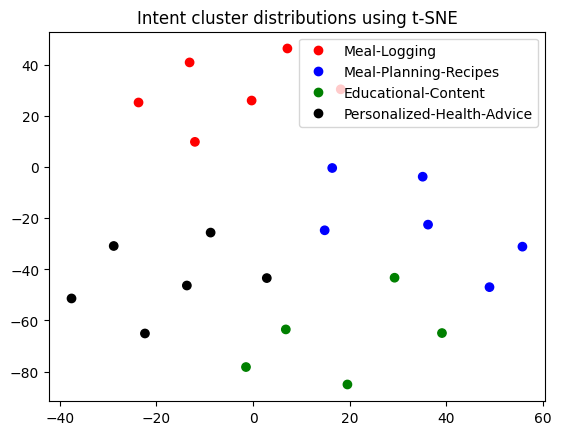

In [19]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

classes = intents
values = [classes.index(label[0]) for label in labels]  #[0, 0, 1, 2, 2, 2]
colors = ListedColormap(['r','b','g', 'black'])

plt.title("Intent cluster distributions using t-SNE")
scatter = plt.scatter(x, y, c=values, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)


In [20]:
for val, _x, _y in zip(values, x, y):
  print (val, (_x, _y))

0 (-0.3092839, 26.097624)
0 (18.140713, 30.497213)
0 (-12.0474205, 9.921176)
0 (-13.14665, 41.017685)
0 (7.097773, 46.478596)
0 (-23.717577, 25.33133)
1 (16.37399, -0.31098312)
1 (36.21024, -22.482061)
1 (14.812852, -24.697046)
1 (55.747375, -31.101334)
1 (35.102345, -3.717047)
1 (48.931503, -46.954674)
2 (-1.4753207, -78.23249)
2 (39.092304, -64.92957)
2 (19.522182, -85.059)
2 (6.768864, -63.5033)
2 (29.279963, -43.265057)
3 (-13.713875, -46.314533)
3 (-28.85401, -30.841778)
3 (2.832253, -43.405205)
3 (-37.59094, -51.38125)
3 (-8.796077, -25.596252)
3 (-22.390963, -65.09282)


In [21]:
# centroid of cluster for each intent
results = []
this_val = -1
this_x = []
this_y = []
for val, _x, _y in zip(values, x, y):
  if val == this_val:
    this_x.append(_x)
    this_y.append(_y)
  else:
    #summarize the prevous this_val
    if (this_val != -1):
      results.append((this_val, np.mean(this_x), np.mean(this_y)))
    # reset
    this_val = val
    this_x = [_x]
    this_y = [_y]
# left-over
if (len(this_x) > 0):
  results.append((this_val, np.mean(this_x), np.mean(this_y)))

print (results)

[(0, -3.9970744, 29.890604), (1, 34.529716, -21.54386), (2, 18.6376, -66.99788), (3, -18.0856, -43.771973)]


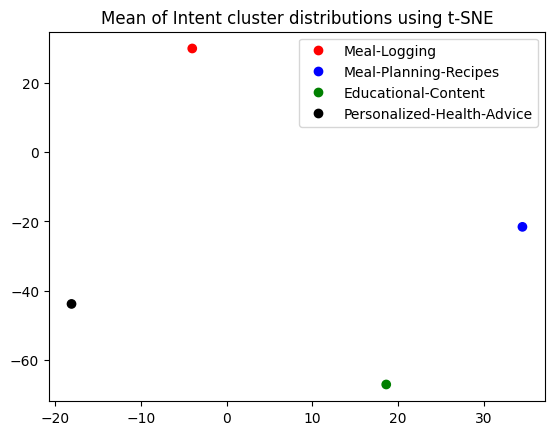

In [22]:
x = [this_x for (intent, this_x, this_y) in results]
y = [this_y for (intent, this_x, this_y) in results]

classes = intents
values = [i for i,_ in enumerate(classes)]
colors = ListedColormap(['r','b','g', 'black'])

plt.title("Mean of Intent cluster distributions using t-SNE")
scatter = plt.scatter(x, y, c=values, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
